<h1>LINEAR REGRESSION</h1>

![](assets/linear-regression.png)

A regression problem is where the output is a real value like __stock price__, __weights__.

In linear regression we assume the __output__ is related to the input variables (which are called __features__) in linear fashion.

Hypothesis (the value we predict) for a input vector X is given as ![](assets/hypothesis.png) when there are _2 features_ i.e. vector X = [x1 x2]

[w0 w1 w2] is called weight vector which we need to find out so that cost is minimal

What is cost?
__Cost function__ is the average sum of absolute squares of the predicted value and actual value for all training input vectors

![](assets/cost-function.png)

We can take partial derivates w.r.t w0, w1, w2 and equate them to 0 and solve the three simultaneous equations to find out the weight values for at which cost function is minimum. But in real world scenarios, there are lot of features so solving those many equations is impractical.

So the approaches we are going to take :-
1. Gradient Descent
2. Stochastic Gradient Descent
3. Gradient Descent along with L1 and L2 regularizations
4. Normal Equations

The problem statement :-

<h3>Predict altitude values given longtitude and latitude values</h3>

The dataset we are going to use is [link](https://archive.ics.uci.edu/ml/datasets/3D+Road+Network+(North+Jutland%2C+Denmark))

We are going to implement all those 4 methods from scratch in python without using any external APIs like scikit-learn.

However we are going to use
* pandas library for data reading purposes
* numpy library for all data manipulation purposes
* matplotlib library to plot the results

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
df = pd.read_csv("assets/dataset.txt", sep = ",", names = ["id", "longtitude", "latitude", "altitude"])

In [14]:
df.head()

,id,longtitude,latitude,altitude
0,144552912,9.349849,56.740876,17.052772
1,144552912,9.350188,56.740679,17.614840
2,144552912,9.350549,56.740544,18.083536
3,144552912,9.350806,56.740484,18.279465
4,144552912,9.351053,56.740486,18.422974


In [43]:
'''
    Feature Scaling :- Using Standardization
'''
# df = (df - df.mean())/df.std()
df = (df - df.min())/(df.max() - df.min())

In [44]:
valueArray = df.to_numpy()

In [45]:
#Splitting dataset using 70-30 cross validation technique
train_size = int(0.7 * valueArray.shape[0])
train_X = valueArray[0:train_size, 1:3]
train_X = np.insert(train_X,0,1,axis=1) #Adding bias
train_Y = valueArray[0:train_size, 3:]
test_X = valueArray[train_size:, 1:3]
test_X = np.insert(test_X,0,1,axis=1) #Adding bias
test_Y = valueArray[train_size:, 3:]

In [46]:
# Testing metrics
train_RMSE = {}
train_R2 = {}
test_RMSE = {}
test_R2 = {}
def RMSE(actualY, predictedY):
    N = actualY.shape[0]
    RMSE = np.sqrt(np.sum((np.power(actualY - predictedY, 2)/N), axis = 0))
    return RMSE
def R2(actualY, predictedY):
    meanY = np.mean(actualY, axis = 0)
    TSS = np.sum(np.power(actualY - meanY, 2), axis = 0)
    RSS = np.sum(np.power(actualY - predictedY, 2), axis = 0)
    return (1 - RSS/TSS)
def get_cost(X, Y, W):
        temp = (X@W.T) - Y
        total_cost = (temp.T @ temp)
        return (0.5/X.shape[0])*total_cost

In [21]:
def gradientDescent(X, Y, alpha, maxIterations, weights):
    """
    This function implements all the batch gradient descent with no regularization.
    At each iteration all the weights are updated with gradient calculated
    over all training points
    """
    # Training
    costs = []
    iters = []
    trainX = X
    trainY = Y
    m = trainX.shape[0]
    prevCost, currCost = 0.0, 0.0
    for iteration in range(maxIterations):
        gradient = np.sum(trainX * (trainX @ weights.T - trainY), axis=0)
        currCost = np.sum(np.power(((trainX @ weights.T) - trainY),2))/(2 * m)
        weights = weights - (alpha/m) * gradient
        #Plotting loss over train set for every 20 iterations
        if iteration % 20 == 0:
            costs.append(currCost)
            iters.append(iteration + 1)
        #Stopping Criterion
        if iteration != 0 and abs(prevCost - currCost) < 1e-10:
            break
        prevCost = currCost
    print("Optimal Cost is {}".format(currCost))
    print("Converting at {}th iteration with learning rate {}".format(iteration+1,alpha))
    plt.title("Gradient Descent")
    plt.xlabel("No Of Iterations")
    plt.ylabel("Cost")
    plt.plot(iters,costs)
    plt.show()
    train_RMSE['batch'] = RMSE(Y, X.dot(weights.T))[0]
    train_R2['batch'] = R2(Y, X.dot(weights.T))[0]
    # Testing
    predicted_Y = test_X.dot(weights.T)
    test_RMSE['batch'] = RMSE(test_Y, predicted_Y)[0]
    test_R2['batch'] = R2(test_Y, predicted_Y)[0]
    return weights

(304411, 3) (304411, 1)
(3,)
Optimal Cost is 0.5103830690889412
Converting at 1th iteration with learning rate 0.01


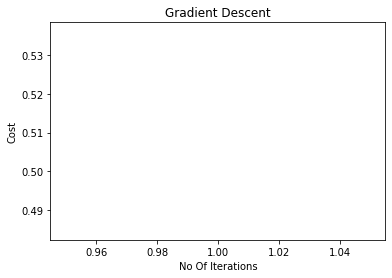

In [22]:
batch_weights = gradientDescent(train_X, train_Y, 0.01, 2000, np.zeros([1,3]))

In [47]:
validation_loss = []
reg_parameters = []
def gradientDescentWithL1Regularization(X, Y, alpha, maxIterations, weights, regParameter):
    """
    This function implements the gradient descents with L1 norm regularization.
    At each iteration all the weights are updated with gradient calculated
    over all training points
    """
    # Training
    costs = []
    iters = []    
    shuffledData = np.concatenate((X, Y), axis = 1)
    np.random.shuffle(shuffledData)
    validationSize = int(0.1 * X.shape[0])
    validationX = X[0:validationSize]
    trainX = X[validationSize:]
    validationY =  Y[0:validationSize]
    trainY = Y[validationSize:]
    m = trainX.shape[0]
    prevCost, currCost = 0.0, 0.0
    for iteration in range(maxIterations):
        c = (regParameter)/(2 * m)
        gradient = np.sum(trainX * (trainX @ weights.T - trainY), axis=0) + np.sign(weights)
        weightList = [weights[0][0], weights[0][1], weights[0][2]]
        weightList = np.asarray(weightList)
        currCost = np.sum(np.power(((trainX @ weights.T) - trainY),2))/(2 * m) + regParameter/(2 * m) * np.linalg.norm(weightList, 1) 
        weights = weights - (alpha/m) * gradient
        #Plotting loss over train set for every 20 iterations
        if iteration%20 == 0:
            costs.append(currCost)
            iters.append(iteration + 1) 
        #Stopping Criterion
        if iteration != 0 and abs(prevCost - currCost) < 1e-10:
            break
        prevCost = currCost
    # Find loss over validation set
    weightList = [weights[0][0], weights[0][1], weights[0][2]]
    weightList = np.asarray(weightList)
    validation_cost = np.sum(np.power(((validationX @ weights.T) - validationY),2))/(2 * m) + regParameter/(2 * m) * np.linalg.norm(weightList, 1)
    validation_loss.append(validation_cost)
    reg_parameters.append(regParameter)
    # Printing the results
    print("Optimal Cost is {}".format(currCost))
    print("Converting at {}th iteration with learning rate {} and {} regularization parameter".format(iteration+1,alpha,regParameter))
    plt.title("Gradient Descent")
    plt.xlabel("No Of Iterations")
    plt.ylabel("Cost")
    plt.plot(iters,costs)
    plt.show()
    train_RMSE['l1'] = RMSE(Y, X.dot(weights.T))[0]
    train_R2['l1'] = R2(Y, X.dot(weights.T))[0]
    # Testing
    predicted_Y = test_X.dot(weights.T)
    test_RMSE['l1'] = RMSE(test_Y, predicted_Y)[0]
    test_R2['l1'] = R2(test_Y, predicted_Y)[0]
    return weights

Optimal Cost is 0.008546739829946083
Converting at 2000th iteration with learning rate 0.02 and -3.5 regularization parameter


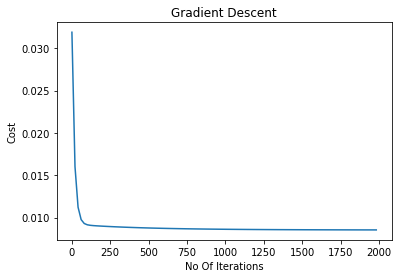

Optimal Cost is 0.008547959931781928
Converting at 2000th iteration with learning rate 0.02 and -1.5 regularization parameter


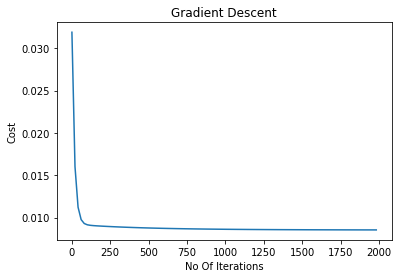

In [ ]:
lis = [-3.5, -1.5 ,0.2 ,0.4 ,0.6 ,1.0]
for reg in lis:
    L1_weights = gradientDescentWithL1Regularization(train_X, train_Y, 0.02, 2000, np.zeros([1,3]), reg)
plt.title("L1 Regularization")
plt.xlabel("Regularization Parameter")
plt.ylabel("Validation Loss")
plt.plot(reg_parameters, validation_loss)

In [40]:
validation_loss = []
reg_parameters = []
def gradientDescentWithL2Regularization(X, Y, alpha, maxIterations, weights, regParameter):
    """
    This function implements the gradient descents with L2 norm regularization.
    At each iteration all the weights are updated with gradient calculated
    over all training points. 
    """
    # Training
    costs = []
    iters = []    
    shuffledData = np.concatenate((X, Y), axis = 1)
    np.random.shuffle(shuffledData)
    validationSize = int(0.1 * X.shape[0])
    validationX = X[0:validationSize]
    trainX = X[validationSize:]
    validationY =  Y[0:validationSize]
    trainY = Y[validationSize:]
    m = trainX.shape[0]
    prevCost, currCost = 0.0, 0.0
    for iteration in range(maxIterations):
        gradient = np.sum(trainX * (trainX @ weights.T - trainY), axis=0)
        weightList = [weights[0][0], weights[0][1], weights[0][2]]
        weightList = np.asarray(weightList)
        currCost = np.sum(np.power(((trainX @ weights.T) - trainY),2))/(2 * m) + regParameter/(2 * m) * np.power(np.linalg.norm(weightList, 2),2) 
        weights = (1 - alpha*regParameter/m)*weights - (alpha/m) * gradient
        #Plotting loss over train set for every 20 iterations
        if iteration%20 == 0:
            costs.append(currCost)
            iters.append(iteration + 1)
        #Stopping Criterion
        if iteration != 0 and abs(prevCost - currCost) < 1e-10:
            break
        prevCost = currCost
     # Find loss over validation set
    weightList = [weights[0][0], weights[0][1], weights[0][2]]
    weightList = np.asarray(weightList)
    validation_cost = np.sum(np.power(((validationX @ weights.T) - validationY),2))/(2 * m) + regParameter/(2 * m) * np.power(np.linalg.norm(weightList, 2),2) 
    validation_loss.append(validation_cost)
    reg_parameters.append(regParameter)
    # Printing the results
    print("Optimal Cost is {}".format(currCost))
    print("Converting at {}th iteration with learning rate {} and {} regularization parameter".format(iteration+1,alpha,regParameter))                             
    plt.title("Gradient Descent")
    plt.xlabel("No Of Iterations")
    plt.ylabel("Cost")
    plt.plot(iters,costs)
    plt.show()
    train_RMSE['l2'] = RMSE(Y, X.dot(weights.T))[0]
    train_R2['l2'] = R2(Y, X.dot(weights.T))[0]
    # Testing
    predicted_Y = test_X.dot(weights.T)
    test_RMSE['l2'] = RMSE(test_Y, predicted_Y)[0]
    test_R2['l2'] = R2(test_Y, predicted_Y)[0]
    return weights

Optimal Cost is 0.5034403105733078
Converting at 369th iteration with learning rate 0.05 and -3.5 regularization parameter


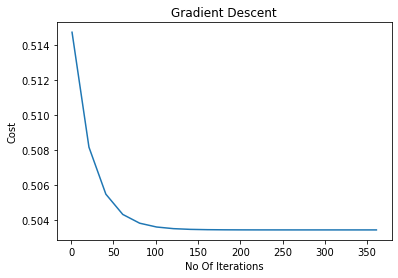

Optimal Cost is 0.5034405044572426
Converting at 369th iteration with learning rate 0.05 and -1.5 regularization parameter


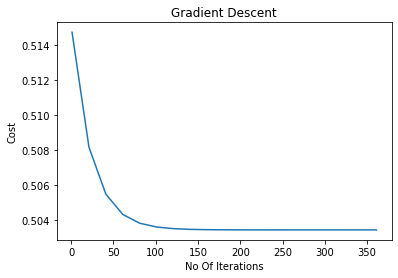

Optimal Cost is 0.5034406692532478
Converting at 369th iteration with learning rate 0.05 and 0.2 regularization parameter


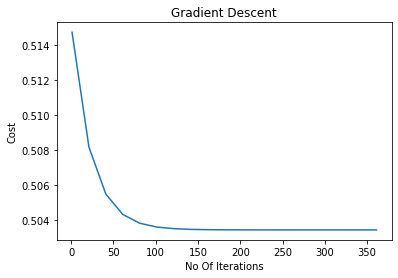

Optimal Cost is 0.5034406886406904
Converting at 369th iteration with learning rate 0.05 and 0.4 regularization parameter


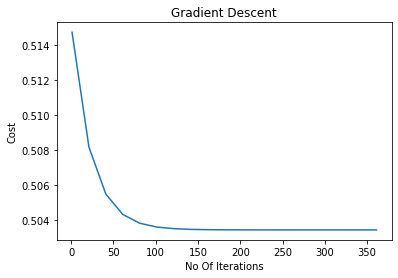

Optimal Cost is 0.5034407080280653
Converting at 369th iteration with learning rate 0.05 and 0.6 regularization parameter


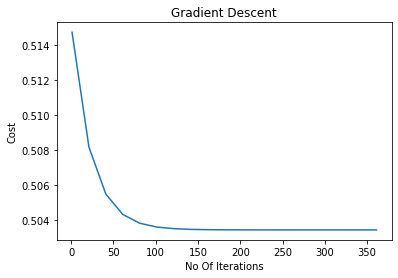

Optimal Cost is 0.5034407468026114
Converting at 369th iteration with learning rate 0.05 and 1.0 regularization parameter


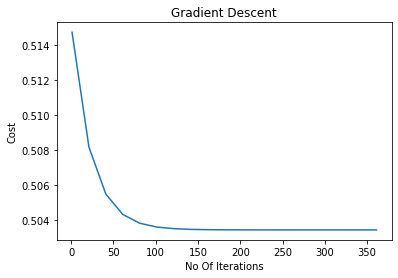

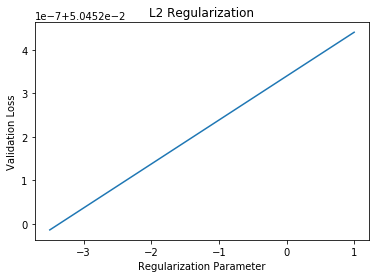

In [41]:
lis = [-3.5, -1.5, 0.2 ,0.4 ,0.6 ,1.0]
for reg in lis:
    L2_weights = gradientDescentWithL2Regularization(train_X, train_Y, 0.05, 2500, np.zeros([1,3]), reg)
plt.title("L2 Regularization")
plt.xlabel("Regularization Parameter")
plt.ylabel("Validation Loss")
plt.plot(reg_parameters, validation_loss)

In [ ]:
def normalEquations(X, Y):
    """
    This function implements vectorization based linear regression.
    AW = B where A = X^T.X, B = X^T.Y. This is known as Normal Equation
    W = inv(A).B
    """  
    # Training
    trainX = X
    trainY = Y
    A = trainX.T.dot(trainX)
    B = trainX.T.dot(trainY)
    weights = np.linalg.inv(A).dot(B)
    train_RMSE['normal'] = RMSE(Y, X.dot(weights))[0]
    train_R2['normal'] = R2(Y, X.dot(weights))[0]
    # Testing
    predicted_Y = test_X.dot(weights)
    test_RMSE['normal'] = RMSE(test_Y, predicted_Y)[0]
    test_R2['normal'] = R2(test_Y, predicted_Y)[0]
    return weights

In [ ]:
normal_weights = normalEquations(train_X, train_Y)

In [116]:
def stochasticGradientDescent(X, Y, alpha, maxIterations, weights):
    """
    This function implements stochastic gradient descent.
    In each iteration, gradient is calculated w.r.t. each training example
    so weights are updated 'm' times in each iteration.
    Every iteration :-
        Random shuffle training set.
        For each point in trainig set calculate gradient and update weights according to it.
    """
    # Training
    costs = []
    iters = []
    prevCost, currCost = 0.0, 0.0
    for iteration in range(maxIterations):
        shuffledData = np.concatenate((X, Y), axis = 1)
        np.random.shuffle(shuffledData)
        trainX = shuffledData[:, 0 : 3]
        trainY = shuffledData[:, 3 :]
        m = trainX.shape[0]
        for index in range(m):
            gradient = trainX[index].dot(weights.T) - trainY[index]
            weights = weights - (alpha/m) * (gradient * trainX[index])
            currCost = np.sum(np.power(((trainX @ weights.T) - trainY),2))/(2 * m)
            
        if iteration % 20 == 0:
            costs.append(currCost)
            iters.append(iteration + 1)    
        #Stopping Criterion
        if iteration != 0 and abs(prevCost - currCost) < 1e-10:
            break
        prevCost = currCost
        
    print("Optimal Cost is {}".format(currCost))
    print("Converting at {}th iteration with learning rate {}".format(iteration+1,alpha))        
    plt.title("Stochastic Gradient Descent")
    plt.xlabel("No Of Iterations")
    plt.ylabel("Cost")
    plt.plot(iters,costs)
    plt.show()
    train_RMSE['stochastic'] = RMSE(Y, X.dot(weights.T))[0]
    train_R2['stochastic'] = R2(Y, X.dot(weights.T))[0]
    # Testing
    predicted_Y = test_X.dot(weights.T)
    test_RMSE['stochastic'] = RMSE(test_Y, predicted_Y)[0]
    test_R2['stochastic'] = R2(test_Y, predicted_Y)[0]
    return weights

In [117]:
stochastic_weights = stochasticGradientDescent(train_X, train_Y, 0.05, 100, np.zeros([1,3]))

KeyboardInterrupt: 

In [ ]:
# Results ->

In [137]:
results_dict = {'Regression Model' : 
                    ['Gradient Descent', 'L1 Regularization', 'L2 Regularization','Stochastic GD','Normal Equations'],
                 'RMSE Training data': 
                    [train_RMSE['batch'], train_RMSE['l1'], train_RMSE['l2'], train_RMSE['stochastic'], train_RMSE['normal']],
                 'R^2 Training data': 
                    [train_R2['batch'], train_R2['l1'], train_R2['l2'], train_R2['stochastic'], train_R2['normal']],
                 'RMSE Testing data': 
                    [test_RMSE['batch'], test_RMSE['l1'], test_RMSE['l2'], train_RMSE['stochastic'], test_RMSE['normal']], 
                 'R^2 Testing data': 
                    [test_R2['batch'], test_R2['l1'], test_R2['l2'], train_R2['stochastic'], test_RMSE['normal']]  
                }
results_df = pd.DataFrame(data = results_dict)

KeyError: 'batch'

In [ ]:
print(results_df)

In [150]:
results_dict = {'Polynomial Regression' : 
                    ['Degree 1','Degree 2','Degree 3','Degree 4','Degree 5', 'Degree 6'],
                 '        RMSE Training data': 
                    ['0.000345567', '0.000341332', '0.000335966', '0.000328003', '0.000324792', '0.000324386']
                }
results_df = pd.DataFrame(data = results_dict)

In [151]:
(results_df)

,Polynomial Regression,RMSE Training data
0,Degree 1,0.000345567
1,Degree 2,0.000341332
2,Degree 3,0.000335966
3,Degree 4,0.000328003
4,Degree 5,0.000324792
5,Degree 6,0.000324386
